In [1]:
# Common stuff

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)

In [2]:
from sklearn import preprocessing

# Stuff we did earlier

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
Ytrain = train.Survived
train.drop('Survived', axis=1, inplace=True)
train['is_test'] = 0
test['is_test'] = 1
df = pd.concat([train, test])
df["isMale"] = df.Sex.replace({"male": 1, "female":0})
df.drop(["Sex", "Ticket", "PassengerId"], axis=1, inplace=True)

# Some more transformations

df["CabinLetter"] = df.Cabin.str.split().str[0].str[:1]
df.drop(["Cabin"], axis=1, inplace=True)

df.CabinLetter.fillna('X', inplace=True)

le_cabinletter = preprocessing.LabelEncoder()
df.CabinLetter = le_cabinletter.fit_transform(df.CabinLetter)

df["Ref"] = df.Name.str.lower().str.split().apply(lambda x: [i for i in x if i in ["mr.", "mrs.", "miss."]]) \
    .apply(lambda x: x[0] if x else "")

le_ref = preprocessing.LabelEncoder()
df.Ref = le_ref.fit_transform(df.Ref)

df.drop(["Name"], axis=1, inplace=True)

df.Embarked.fillna('X', inplace=True)

le_embarked = preprocessing.LabelEncoder()
df.Embarked = le_embarked.fit_transform(df.Embarked)

imputer = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)
imputer.fit(df[df.is_test == 0])
df_imp = imputer.transform(df)
df = pd.DataFrame(df_imp, columns = df.columns)

print(le_ref.classes_)
print(le_cabinletter.classes_)
print(le_embarked.classes_)

df.info()

['' 'miss.' 'mr.' 'mrs.']
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'T' 'X']
['C' 'Q' 'S' 'X']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 10 columns):
Pclass         1309 non-null float64
Age            1309 non-null float64
SibSp          1309 non-null float64
Parch          1309 non-null float64
Fare           1309 non-null float64
Embarked       1309 non-null float64
is_test        1309 non-null float64
isMale         1309 non-null float64
CabinLetter    1309 non-null float64
Ref            1309 non-null float64
dtypes: float64(10)
memory usage: 112.5 KB


In [3]:
# Split, now we have our Xtrain, Xtest and Ytrain

Xtrain = df[df.is_test == 0].copy()
Xtest = df[df.is_test == 1].copy()

Xtrain.drop(["is_test"], axis=1, inplace=True)
Xtest.drop(["is_test"], axis=1, inplace=True)

print(Xtrain.shape)
print(Xtest.shape)
print(Ytrain.shape)

(891, 9)
(418, 9)
(891,)


In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

depths = np.arange(1,10)
features_num = np.arange(1, Xtrain.shape[1] + 1)
grid = {'max_depth': depths, 'max_features': features_num, 'random_state' : [0]}
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, scoring='neg_log_loss', cv=5)

In [5]:
%%time
gridsearch.fit(Xtrain, Ytrain)

CPU times: user 1.52 s, sys: 0 ns, total: 1.52 s
Wall time: 1.52 s


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'max_features': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

In [6]:
sorted(gridsearch.grid_scores_, key = lambda x: -x.mean_validation_score)[:15]

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.45225, std: 0.02685, params: {'max_depth': 2, 'max_features': 5, 'random_state': 0},
 mean: -0.45225, std: 0.02685, params: {'max_depth': 2, 'max_features': 8, 'random_state': 0},
 mean: -0.46213, std: 0.03321, params: {'max_depth': 2, 'max_features': 7, 'random_state': 0},
 mean: -0.46213, std: 0.03321, params: {'max_depth': 2, 'max_features': 9, 'random_state': 0},
 mean: -0.46468, std: 0.00920, params: {'max_depth': 3, 'max_features': 3, 'random_state': 0},
 mean: -0.47282, std: 0.02518, params: {'max_depth': 2, 'max_features': 6, 'random_state': 0},
 mean: -0.47670, std: 0.02399, params: {'max_depth': 3, 'max_features': 1, 'random_state': 0},
 mean: -0.48023, std: 0.10711, params: {'max_depth': 3, 'max_features': 4, 'random_state': 0},
 mean: -0.49366, std: 0.01509, params: {'max_depth': 2, 'max_features': 3, 'random_state': 0},
 mean: -0.50814, std: 0.02300, params: {'max_depth': 2, 'max_features': 4, 'random_state': 0},
 mean: -0.51588, std: 0.02661, params: {'max_depth

In [7]:
clf_final = DecisionTreeClassifier(max_depth=2, max_features=5, random_state=0)
clf_final.fit(Xtrain, Ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [8]:
# We're done, let's calc Ytest

from sklearn.metrics import accuracy_score

Ytest_proba = clf_final.predict_proba(Xtest)
Ytest = clf_final.predict(Xtest)

Ytrain_guess = clf_final.predict(Xtrain)
Ytrain_guess_proba = clf_final.predict_proba(Xtrain)

# And get some very simple metrics

accuracy_score(Ytrain, Ytrain_guess)

0.78675645342312006

([<matplotlib.axis.YTick at 0x7ff42ebdcb70>,
 <a list of 9 Text yticklabel objects>)

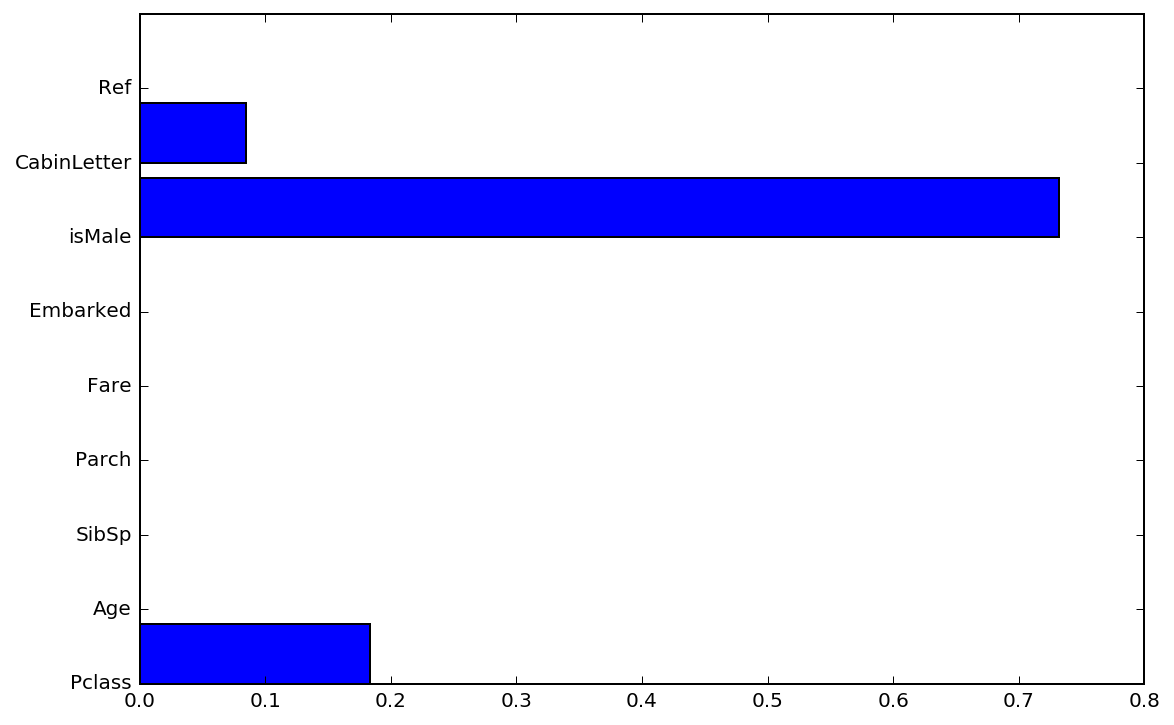

In [9]:
# Let's also plot feature importance

plt.barh(np.arange(len(clf_final.feature_importances_)), clf_final.feature_importances_)
plt.yticks(np.arange(len(Xtrain.columns)),Xtrain.columns)

# So, our introduced mr. mrs., etc. doesn't make much sense, cabin letter is pretty useful though

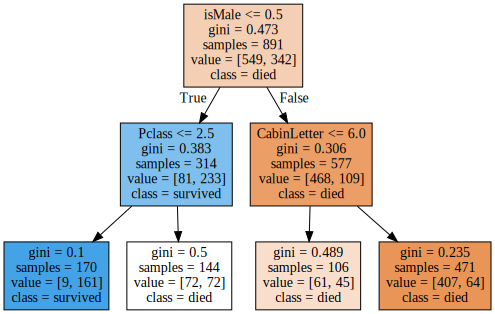

In [10]:
# Let's visualize the tree

from sklearn.tree import export_graphviz
import graphviz

export_graphviz(clf_final, out_file="part_1.dot", filled=True, feature_names=list(Xtrain.columns), class_names=["died", "survived"])
with open("part_1.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [11]:
# Let's submit

sample_submission = pd.read_csv('gender_submission.csv')
submit = pd.DataFrame(Ytest, columns=sample_submission.columns[1:])
submit['PassengerId'] = sample_submission.PassengerId
submit = submit[[submit.columns[-1]]+list(submit.columns[:-1])]
submit.to_csv('submit.csv', index=False)

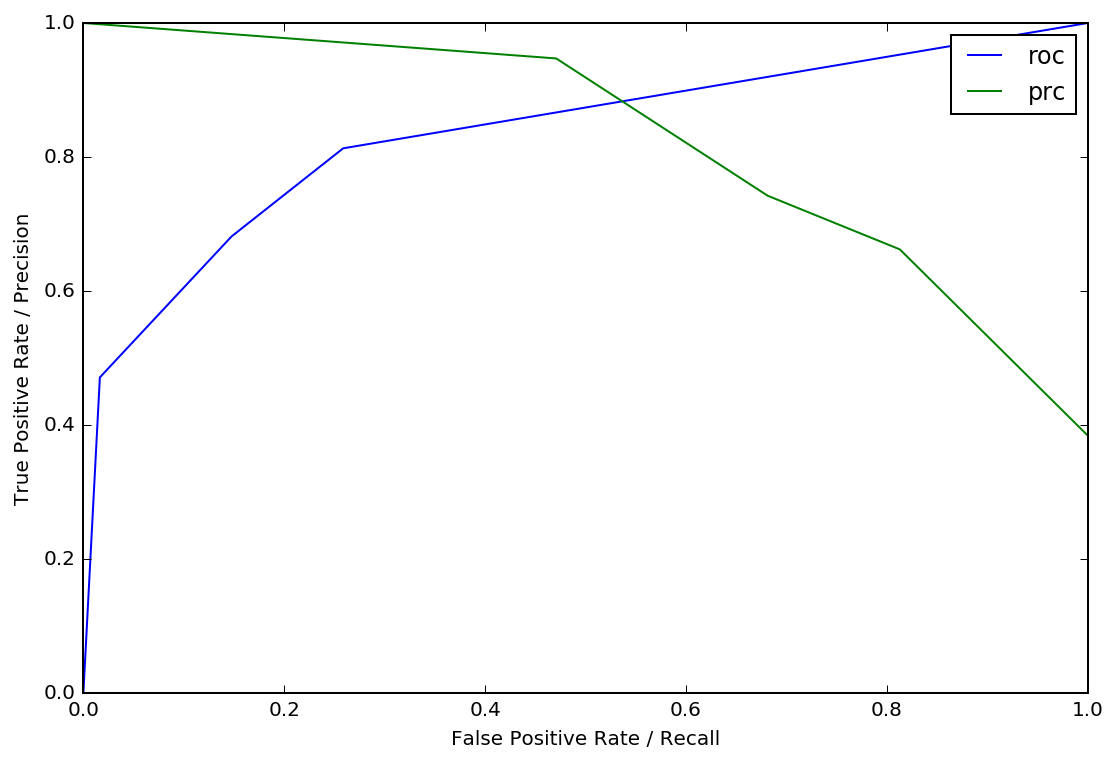

roc-auc = 0.834393
prc-auc = 0.826311
roc-auc ours: 0.834393
prc-auc ours: 0.826311


In [12]:
### LVL2 ####

# Let's write our own roc-auc and roc-prc
# First, let's calc and draw using sklearn

from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score
fpr, tpr, _ = roc_curve(Ytrain, Ytrain_guess_proba[:, 1])
pr, re, _ = precision_recall_curve(Ytrain, Ytrain_guess_proba[:, 1])
plt.plot(fpr, tpr, label = 'roc')
plt.plot(re, pr, label = 'prc')
plt.xlabel('False Positive Rate / Recall')
plt.ylabel('True Positive Rate / Precision')
plt.legend()
plt.show()

from sklearn.metrics import auc

print("roc-auc = %f" % roc_auc_score(Ytrain, Ytrain_guess_proba[:, 1]))
print("prc-auc = %f" % auc(re, pr))

# Now let's write our own

from sklearn.metrics import precision_score, recall_score

probs = np.unique(np.sort(Ytrain_guess_proba[:, 1]))
ps_arr = [1]
rs_arr = [0]
fp_arr = [0]
for p in probs:
    res = np.array([1 if item >= p else 0 for item in Ytrain_guess_proba[:, 1]])
    ps = precision_score(Ytrain, res)
    rs = recall_score(Ytrain, res)
    ps_arr.append(ps)
    rs_arr.append(rs)        
    fp = np.count_nonzero((res == 1) & (Ytrain == 0))
    tn = np.count_nonzero((res == 0) & (Ytrain == 0))
    fp_arr.append(fp / (fp + tn))    
print("roc-auc ours: %f" % auc(fp_arr, rs_arr, reorder=True))
print("prc-auc ours: %f" % auc(rs_arr, ps_arr, reorder=True))